In [1]:
import numpy as np
import pandas as pd 
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import sys
import time
import tensorflow.keras as keras
import tensorflow as tf
import re

from PIL import Image
from keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling2D, Input, GlobalAveragePooling2D
from keras.models import Model, Sequential
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.layers import Lambda
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras.preprocessing import image


2022-11-14 05:59:48.048326: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Definir o tamanho das imagens | Se baixar o tamanho, a eficácia é reduzida para menos de metade!!
IMAGE_WIDTH = 224    
IMAGE_HEIGHT = 224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3


# Caminho das imagens
base_path = "/home/manu/Documents/TP_IC/archive/garbage_classification/"

# 10 classes
categories = {0: 'paper', 1: 'cardboard', 2: 'plastic', 3: 'metal', 4: 'trash', 5: 'battery',
              6: 'shoes', 7: 'clothes', 8: 'glass', 9: 'biological'}

In [3]:
# Função que tranforma isto "/paper104.jpg" em isto "paper/paper104.jpg"
def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x[:re.search("\d",x).start()] + '/' + x)
    return df

# Lista com os filenames do dataset
filenames_list = []

# Lista para guardar as categorias
categories_list = []

# Preenche as listas
for category in categories:
    filenames = os.listdir(base_path + categories[category])
    
    filenames_list = filenames_list  +filenames
    categories_list = categories_list + [category] * len(filenames)

# Atribui ao dataframe os valores
df = pd.DataFrame({
    'filename': filenames_list,
    'category': categories_list
})

# Chama a função para adicionar o nome na directoria
df = add_class_name_prefix(df, 'filename')

# Baralha o dataframe
df = df.sample(frac=1).reset_index(drop=True)

print('Número total de imagens do Dataset = ' , len(df))

Número total de imagens do Dataset =  15515


In [4]:
# Mostra as 5 primeiras
df.head()

,filename,category
0,plastic/plastic436.jpg,2
1,shoes/shoes640.jpg,6
2,plastic/plastic131.jpg,2
3,shoes/shoes1410.jpg,6
4,clothes/clothes4683.jpg,7


paper/paper885.jpg


/home/manu/anaconda3/envs/tensorflow/lib/python3.10/site-packages/keras/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


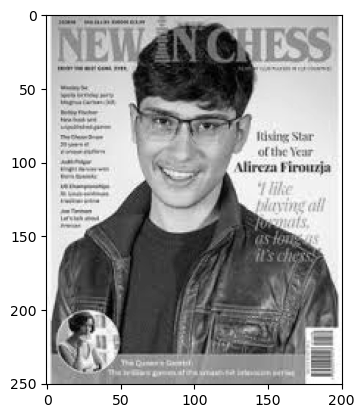

In [5]:
# Vai buscar uma linha random, com essa linha o sample vai guardar vários dados de modo a 
# ir buscar uma imagem aleatoria
random_row = random.randint(0, len(df)-1)

sample = df.iloc[random_row]

randomimage = image.load_img(base_path +sample['filename'], grayscale=True )
print(sample['filename'])
plt.imshow(randomimage, cmap='gray' )

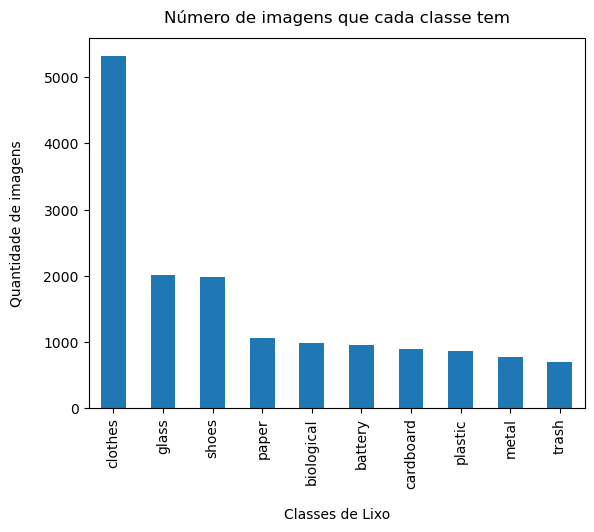

In [6]:
# Mostra quantas imagens cada classe tem. Dá jeito para confirmar que as imagens estão a ser todas reconhecidas
df_visualization = df.copy()

df_visualization['category'] = df_visualization['category'].apply(lambda x:categories[x] )

df_visualization['category'].value_counts().plot.bar(x = 'count', y = 'category' )

plt.xlabel("Classes de Lixo", labelpad=14)
plt.ylabel("Quantidade de imagens", labelpad=14)
plt.title("Número de imagens que cada classe tem", y=1.02);

In [7]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
import keras.applications.mobilenet_v2 as mobilenetv2

# mobilenetv2 é um modelo (deep learning) do tipo CNN que é pré-treinado, ou seja,
# já foi treinada para classificar imagens, sendo esta capaz de classificar
# 1000 categorias das mesmas
mobilenetv2_layer = mobilenetv2.MobileNetV2(include_top = False, input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS),
                       weights = 'imagenet')

# O modelo mobilenetv2 já está pré-treinado, logo, não queremos que estas camadas que ele tras
# sejam treinadas novamente pelo tensorflow
mobilenetv2_layer.trainable = False

model = Sequential()

model.add(keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))

# Cria uma camada para aplicar o preprocessamento na imagem, para ter as caracteristicas pretendidas
def mobilenetv2_preprocessing(img):
  return mobilenetv2.preprocess_input(img)

model.add(Lambda(mobilenetv2_preprocessing))

#model.add(tf.keras.layers.BatchNormalization()) | Demora mt tempo a treinar com esta camada +/- 15 por epoch

# Camadas pre treinadas
model.add(mobilenetv2_layer)


model.add(tf.keras.layers.GlobalAveragePooling2D())
#model.add(Flatten(name="featuresCamadaFlatten"))
model.add(tf.keras.layers.Dropout(0.8))
model.add(Dense(len(categories), activation='softmax')) 


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
model.summary()


#feature_extractor = keras.Model(
#    inputs=model.inputs,
#    outputs=model.get_layer(name="featuresCamadaFlatten").output,
#)

#x = tf.ones((1, 224, 224, 3))
#features = feature_extractor(x)
#print("Número de Features da Camada featuresCamadaFlatten:")
#print(features)

2022-11-14 05:59:49.969647: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 10)                12810     
                                                                 
Total params: 2,270,794
Trainable params: 12,810
Non-tra

In [8]:
early_stop = EarlyStopping(patience = 2, verbose = 1, monitor='val_categorical_accuracy' , mode='max', min_delta=0.001, restore_best_weights = True)

callbacks = [early_stop]

#print('early stop definido')

In [9]:
# Muda as categorias de numeros para nome
df["category"] = df["category"].replace(categories) 

# Dividimos o nosso dataset em treino, validação e teste, de modo a ter dados mais fidedignos e não
# tão tendenciosos. 80% para treino, 10% para validação e 10% para teste
# Ao dividir em validação permite-nos ver se o modelo está em overfitting, gera-nos outros dados que não
# os de treino
train_df, validate_df = train_test_split(df, test_size=0.2, random_state=42)
validate_df, test_df = train_test_split(validate_df, test_size=0.5, random_state=42)

train_df = train_df.reset_index(drop=True) 
validate_df = validate_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

total_train = train_df.shape[0] 
total_validate = validate_df.shape[0] 

print('Num Imagens de Treino = ', total_train , '  Num Imagens de Validação = ', total_validate, '  Num Imagens de Teste = ', test_df.shape[0])

Num Imagens de Treino =  12412   Num Imagens de Validação =  1551   Num Imagens de Teste =  1552


In [10]:
batch_size=64

train_datagen = image.ImageDataGenerator(
    
    ###  Augmentation Start  ###
    
    #rotation_range=30,
    #shear_range=0.1,
    #zoom_range=0.3,
    #horizontal_flip=True,
    #vertical_flip = True,
    #width_shift_range=0.2,
    #height_shift_range=0.2
    
    ##  Augmentation End  ###
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    base_path, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 12412 validated image filenames belonging to 10 classes.


In [11]:
validation_datagen = image.ImageDataGenerator()

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    base_path, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 1551 validated image filenames belonging to 10 classes.


In [12]:
EPOCHS = 20
history = model.fit_generator(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

/tmp/ipykernel_134229/2716048666.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/20
193/193 [==============================] - 277s 1s/step - loss: 1.3055 - categorical_accuracy: 0.6368 - val_loss: 0.3009 - val_categorical_accuracy: 0.9004
Epoch 2/20
193/193 [==============================] - 271s 1s/step - loss: 0.5761 - categorical_accuracy: 0.8201 - val_loss: 0.2306 - val_categorical_accuracy: 0.9310
Epoch 3/20
193/193 [==============================] - 268s 1s/step - loss: 0.4681 - categorical_accuracy: 0.8553 - val_loss: 0.2161 - val_categorical_accuracy: 0.9342
Epoch 4/20
193/193 [==============================] - 269s 1s/step - loss: 0.4186 - categorical_accuracy: 0.8704 - val_loss: 0.2097 - val_categorical_accuracy: 0.9264
Epoch 5/20
193/193 [==============================] - 268s 1s/step - loss: 0.3982 - categorical_accuracy: 0.8747 - val_loss: 0.1939 - val_categorical_accuracy: 0.9388
Epoch 6/20
193/193 [==============================] - 265s 1s/step - loss: 0.3931 - categorical_accuracy: 0.8757 - val_loss: 0.1854 - val_categorical_accuracy: 0.938

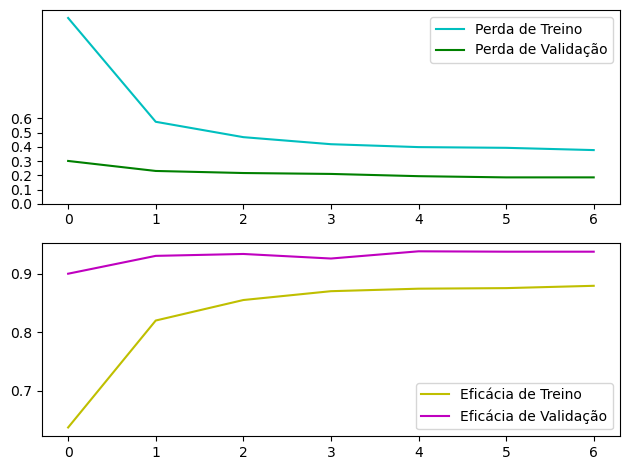

In [13]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(history.history['loss'], color='c', label="Perda de Treino")
ax1.plot(history.history['val_loss'], color='g', label="Perda de Validação")
ax1.set_yticks(np.arange(0, 0.7, 0.1))
ax1.legend()

ax2.plot(history.history['categorical_accuracy'], color='y', label="Eficácia de Treino")
ax2.plot(history.history['val_categorical_accuracy'], color='m',label="Eficácia de Validação")
ax2.legend()

legend = plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [14]:
test_datagen = image.ImageDataGenerator()

test_generator = test_datagen.flow_from_dataframe(
    dataframe= test_df,
    directory=base_path,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False 
)

Found 1552 validated image filenames belonging to 10 classes.


In [15]:
filenames = test_generator.filenames
nb_samples = len(filenames)

_, accuracy = model.evaluate_generator(test_generator, nb_samples)

print('Eficácia de teste = ',  round((accuracy * 100),2 ), '% ') 

/tmp/ipykernel_134229/4263862410.py:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  _, accuracy = model.evaluate_generator(test_generator, nb_samples)


Eficácia de teste =  94.39 % 


In [16]:
# No inicio definimos as nossas proprias classes, no entanto, o gerador de treino gera as suas proprias
# Logo estas têm diferentes números para as nossas categorias/classes
# As previsões serão feitas com base no numero das classes do gerador

gen_label_map = test_generator.class_indices
gen_label_map = dict((v,k) for k,v in gen_label_map.items())
print(gen_label_map)

{0: 'battery', 1: 'biological', 2: 'cardboard', 3: 'clothes', 4: 'glass', 5: 'metal', 6: 'paper', 7: 'plastic', 8: 'shoes', 9: 'trash'}


In [17]:
# Mete na previsão do modelo os nossos dados de teste
preds = model.predict_generator(test_generator, nb_samples)

# Vais buscar o NUMERO da categoria com a probabilidade de previsão mais alta
preds = preds.argmax(1)

# Por isso é que aqui é convertido o NUMERO da categoria para o NOME dela
preds = [gen_label_map[item] for item in preds]

# Converte o dataframe para uma matriz
labels = test_df['category'].to_numpy()

print(classification_report(labels, preds))

/tmp/ipykernel_134229/3845457007.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  preds = model.predict_generator(test_generator, nb_samples)


              precision    recall  f1-score   support

     battery       0.95      0.93      0.94        94
  biological       0.96      0.96      0.96       112
   cardboard       0.94      0.92      0.93        88
     clothes       0.99      0.99      0.99       564
       glass       0.91      0.89      0.90       182
       metal       0.82      0.82      0.82        76
       paper       0.88      0.93      0.91       104
     plastic       0.87      0.81      0.84        88
       shoes       0.94      0.99      0.97       177
       trash       0.95      0.94      0.95        67

    accuracy                           0.94      1552
   macro avg       0.92      0.92      0.92      1552
weighted avg       0.94      0.94      0.94      1552

